## Prepare adata object

In [1]:
import scanpy as sc
import anndata as ad
from scipy import io
import numpy as np
import pandas as pd
import scvelo as scv
import cellrank as cr

In [2]:
scv.settings.verbosity = 2
scv.settings.presenter_view = True
scv.settings.set_figure_params(facecolor='white',
                               dpi_save=300,
                               frameon='artist',
                               vector_friendly=True,
                               figsize=(4,6),
                               transparent=True)
scv.settings.plot_prefix = 'uninfected/uninfected_'
cr.settings.verbosity = 2

In [3]:
# To match ggplot2 colours in Seurat:
main_celltype_palette={'Epithelial':'#F6766D','Fibroblast':'#A2A402',
                       'Immune':'#00BD7C','Neurons':'#00AEF4','Vascular':'#E46AF1'}

colour_palette={'Basal':"#F0A0FF", 'Dendritic cells':"#0075DC",
                'Endothelial cells':"#993F00", 'Fibroblast':"#4C005C",
                'Macrophages':"#191919", 'Memory T cells':"#005C31",
                'Neurons':"#2BCE48", 'Neutrophils':"#FFCC99",
                'Outer bulge': "#808080", 'Sebacious gland':"#94FFB5",
                'Suprabasal':"#8F7C00",
                'Upper hair follicle suprabasal':"#9DCC00",
                'Vascular smooth muscle':"#C20088"}

cluster_palette={'MAC1':"#aa0dfe", 'FIB1':"#3283fe",
                 'FIB2':"#85660d", 'BAS1':"#782ab6",
                 'SUP1':"#565656",'HFSUP1':"#1c8356",
                 'SG':"#16FF32", 'NEUT1':"#F7E1A0",
                 'SUP2':"#E2E2E2", 'MAC2':"#1CBE4F",
                 'SUP3':"#C4451C", 'EC1':"#DEA0FD",
                 'EC2':"#FE00FA", 'SUP4':"#325A9B",
                 'OB':"#FEAF16", 'FIB3':"#F8A19F",
                 'HFSUP2':"#90AD1C", 'DC':"#F6222E",
                 'VSM':"#1CFFCE", 'NEU':"#2ED9FF",
                 'NEUT2':"#B10DA1", 'BAS3':"#C075A6",
                 'TMEM':"#FC1CBF", 'BAS2':"#B00068"}

In [ ]:
X = io.mmread("data/uninfected_counts.mtx")

In [ ]:
adata = ad.AnnData(
    X=X.transpose().tocsr(), dtype=X.dtype
)

# load cell metadata pre-calculated in Seurat:
cell_meta = pd.read_csv("data/uninfected_metadata.csv")

# load gene names pre-calculated in Seurat:
with open("data/uninfected_gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

# load barcodes pre-calculated in Seurat:
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

# load dimensional reduction pre-calculated in Seurat:
pca = pd.read_csv("data/uninfected_pca.csv")
pca.index = adata.obs.index

In [ ]:
# set pca and umap pre-calculated in Seurat:
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

# plot a UMAP colored by celltypes to test:
sc.pl.umap(adata,
           color='seurat_clusters',
           frameon=False,
           palette=cluster_palette)

In [ ]:
# read .loom files created in velocyto for each sample in the integrated dataset
ldata1 = scv.read('loom/uninfected_1.loom', cache=False, validate=False)
ldata2 = scv.read('loom/uninfected_2.loom', cache=False, validate=False)

In [ ]:
# rename barcodes in order to merge
barcodes = [bc.split(':')[1] for bc in ldata1.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_1' for bc in barcodes]
ldata1.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in ldata2.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_2' for bc in barcodes]
ldata2.obs.index = barcodes

In [ ]:
ldata1.var_names_make_unique()
ldata2.var_names_make_unique()

In [ ]:
# concatenate loom data
ldata = ldata1.concatenate(ldata2)

In [ ]:
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(ldata)

In [ ]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

# save dataset as anndata format
adata.write('adata/uninfected.h5ad')

# scVelo

In [ ]:
scv.pl.proportions(adata, groupby='celltype_2nd', save = 'spliced_unspliced.pdf')

## Dynamical model

In [4]:
#adata = scv.read('adata/uninfected.h5ad')

In [5]:
# immune cells
immune = ['MAC1', 'MAC2']
adata = adata[adata.obs['seurat_clusters'].isin(immune)]

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=14, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20396 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:00)


In [7]:
scv.tl.recover_dynamics(adata, n_jobs = 10)

recovering dynamics (using 10/12 cores)


  0%|          | 0/366 [00:00<?, ?gene/s]

    finished (0:00:36)


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [8]:
scv.tl.velocity(adata, mode = 'dynamical', n_jobs = 10, diff_kinetics=True)
scv.tl.velocity_graph(adata, n_jobs = 10)

computing velocities
    finished (0:00:01)
computing velocity graph (using 10/12 cores)


  0%|          | 0/1912 [00:00<?, ?cells/s]

    finished (0:00:04)


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


In [ ]:
# save for later
#adata.write('processed_adata/uninfected.h5ad', compression='gzip')
adata = scv.read('processed_adata/uninfected.h5ad')

computing velocity embedding
    finished (0:00:00)
saving figure to file ./figures/uninfected/uninfected_immune_velocity_stream.svg


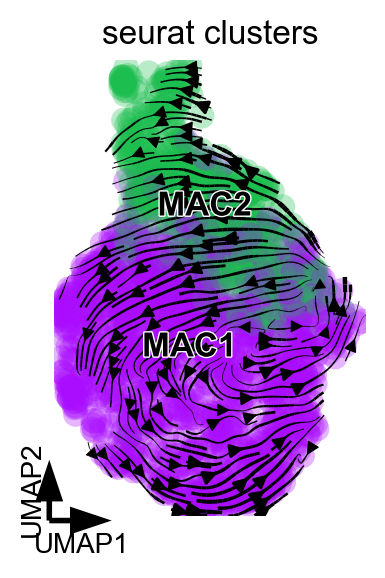

In [9]:
scv.pl.velocity_embedding_stream(adata,
                                 basis = 'umap',
                                 smooth = 0.8,
                                 min_mass = 3,
                                 color = 'seurat_clusters',
                                 figsize = (2,3),
                                 palette = cluster_palette,
                                 save = 'immune_velocity_stream.svg'
                                )

# CellRank

## Identify terminal states

In [10]:
cr.tl.terminal_states(adata,
                      cluster_key="seurat_clusters",
                      weight_connectivities=0.2)

Accessing `adata.obsp['T_fwd']`
Computing transition matrix based on logits using `'deterministic'` mode


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_31727/2206854306.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata,
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/1912 [00:00<?, ?cell/s]

Setting `softmax_scale=3.0022`


  0%|          | 0/1912 [00:00<?, ?cell/s]

    Finish (0:00:03)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:00)
For 1 macrostate, stationary distribution is computed
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file figures/uninfected/uninfected_immune_cellrank_terminal_states.pdf


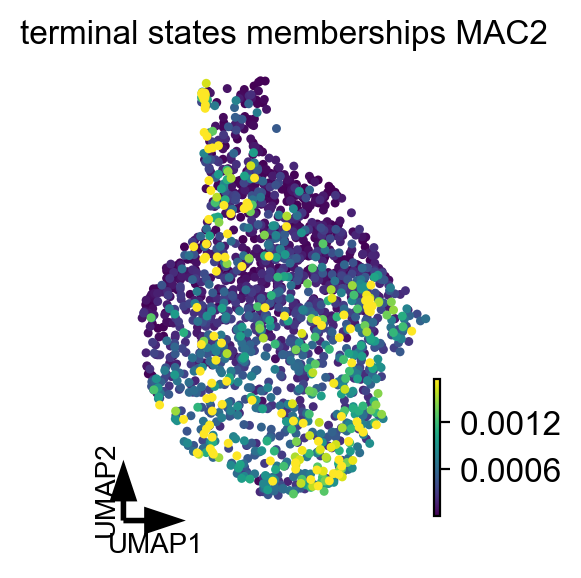

In [11]:
cr.pl.terminal_states(adata,
                      figsize = (2,3),
                      save = 'figures/uninfected/uninfected_immune_cellrank_terminal_states.pdf'
                      )

## Identify initial states

Accessing `adata.obsp['T_bwd']`
Computing transition matrix based on logits using `'deterministic'` mode


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_31727/3807219072.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata,
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/1912 [00:00<?, ?cell/s]

Setting `softmax_scale=3.0022`


  0%|          | 0/1912 [00:00<?, ?cell/s]

    Finish (0:00:04)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_bwd']`
       `.eigendecomposition`
    Finish (0:00:00)
For 1 macrostate, stationary distribution is computed
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file figures/uninfected/uninfected_immune_cellrank_initial_states.pdf


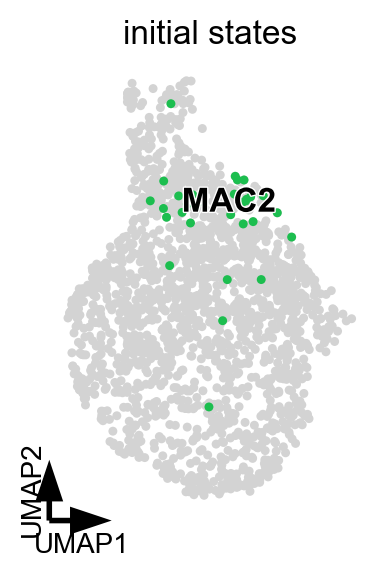

In [12]:
cr.tl.initial_states(adata,
                     cluster_key = 'seurat_clusters')

cr.pl.initial_states(adata,
                     discrete = True,
                     figsize = (2,3),
                     save = 'figures/uninfected/uninfected_immune_cellrank_initial_states.pdf'
                    )

Computing absorption probabilities
Defaulting to `'gmres'` solver.


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_31727/288425463.py:2: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)


  0%|          | 0/1 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file figures/uninfected/uninfected_immune_cellrank_lineages.pdf


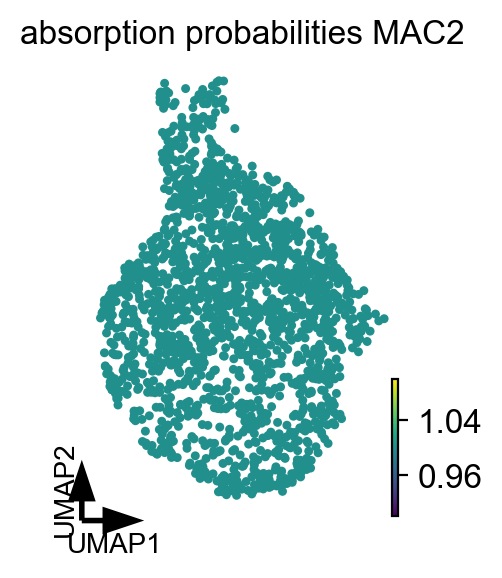

In [13]:
# Compute fate maps
cr.tl.lineages(adata)

cr.pl.lineages(adata,
               same_plot = False,
               figsize = (2,3),
               save = 'figures/uninfected/uninfected_immune_cellrank_lineages.pdf'
              )

In [14]:
# Directed PAGA
scv.tl.recover_latent_time(adata,
                           root_key="initial_states_probs",
                           end_key="terminal_states_probs")

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00)


In [15]:
scv.tl.paga(adata,
            groups="seurat_clusters",
            root_key="initial_states_probs",
            end_key="terminal_states_probs",
            use_time_prior="velocity_pseudotime")

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:00)


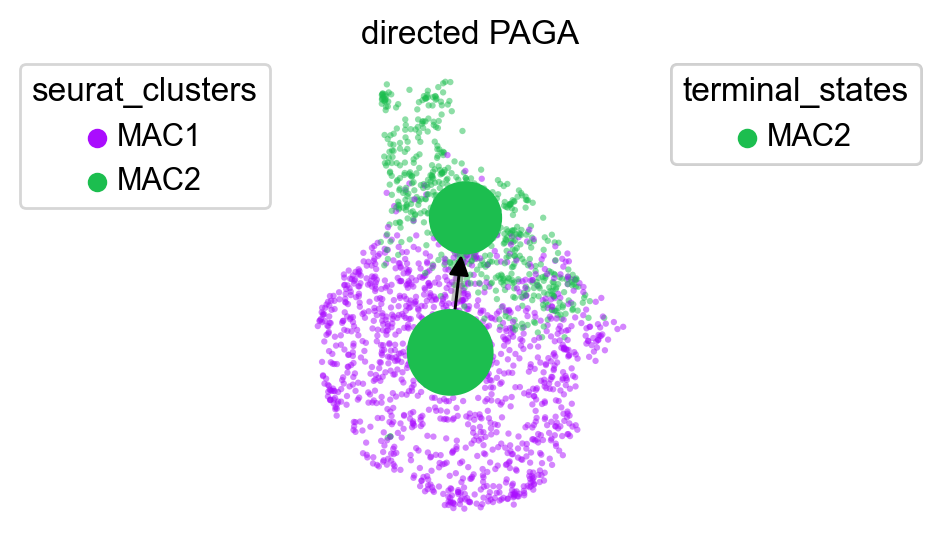

In [16]:
cr.pl.cluster_fates(adata,
                    mode="paga_pie",
                    cluster_key="seurat_clusters",
                    basis="umap",
                    legend_kwargs={"loc": "top right out"},
                    legend_loc="top left out",
                    node_size_scale=5,
                    edge_width_scale=1,
                    max_edge_width=4,
                    figsize = (2.5,3),
                    title="directed PAGA",
                    save = 'uninfected/uninfected_immune_cluster_fates.svg'
                   )

## Compute lineage drivers

In [17]:
cr.tl.lineage_drivers(adata)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_31727/775505281.py:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata)


MAC2_corr     MAC2_pval     MAC2_qval  MAC2_ci_low  MAC2_ci_high
Fn1      0.251717  2.605613e-29  5.211227e-26     0.209250      0.293237
Thbs1    0.220637  1.111949e-22  7.412994e-20     0.177565      0.262865
Cd14     0.202388  3.059985e-19  1.019995e-16     0.159002      0.244993
Plcb1    0.199622  9.519781e-19  2.719937e-16     0.156191      0.242282
Il1b     0.185478  2.428000e-16  5.395555e-14     0.141828      0.228407
...           ...           ...           ...          ...           ...
Fnip2   -0.181511  1.062158e-15  1.931196e-13    -0.224513     -0.137804
Snx24   -0.195588  4.834377e-18  1.208594e-15    -0.238327     -0.152094
Fnip1   -0.207431  3.695725e-20  1.478290e-17    -0.249936     -0.164129
Malat1  -0.208706  2.147181e-20  1.073590e-17    -0.251184     -0.165425
Apoe    -0.241427  5.267434e-27  5.267434e-24    -0.283190     -0.198749

[2000 rows x 5 columns]

### Top 12 driver genes for MAC2

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all functi

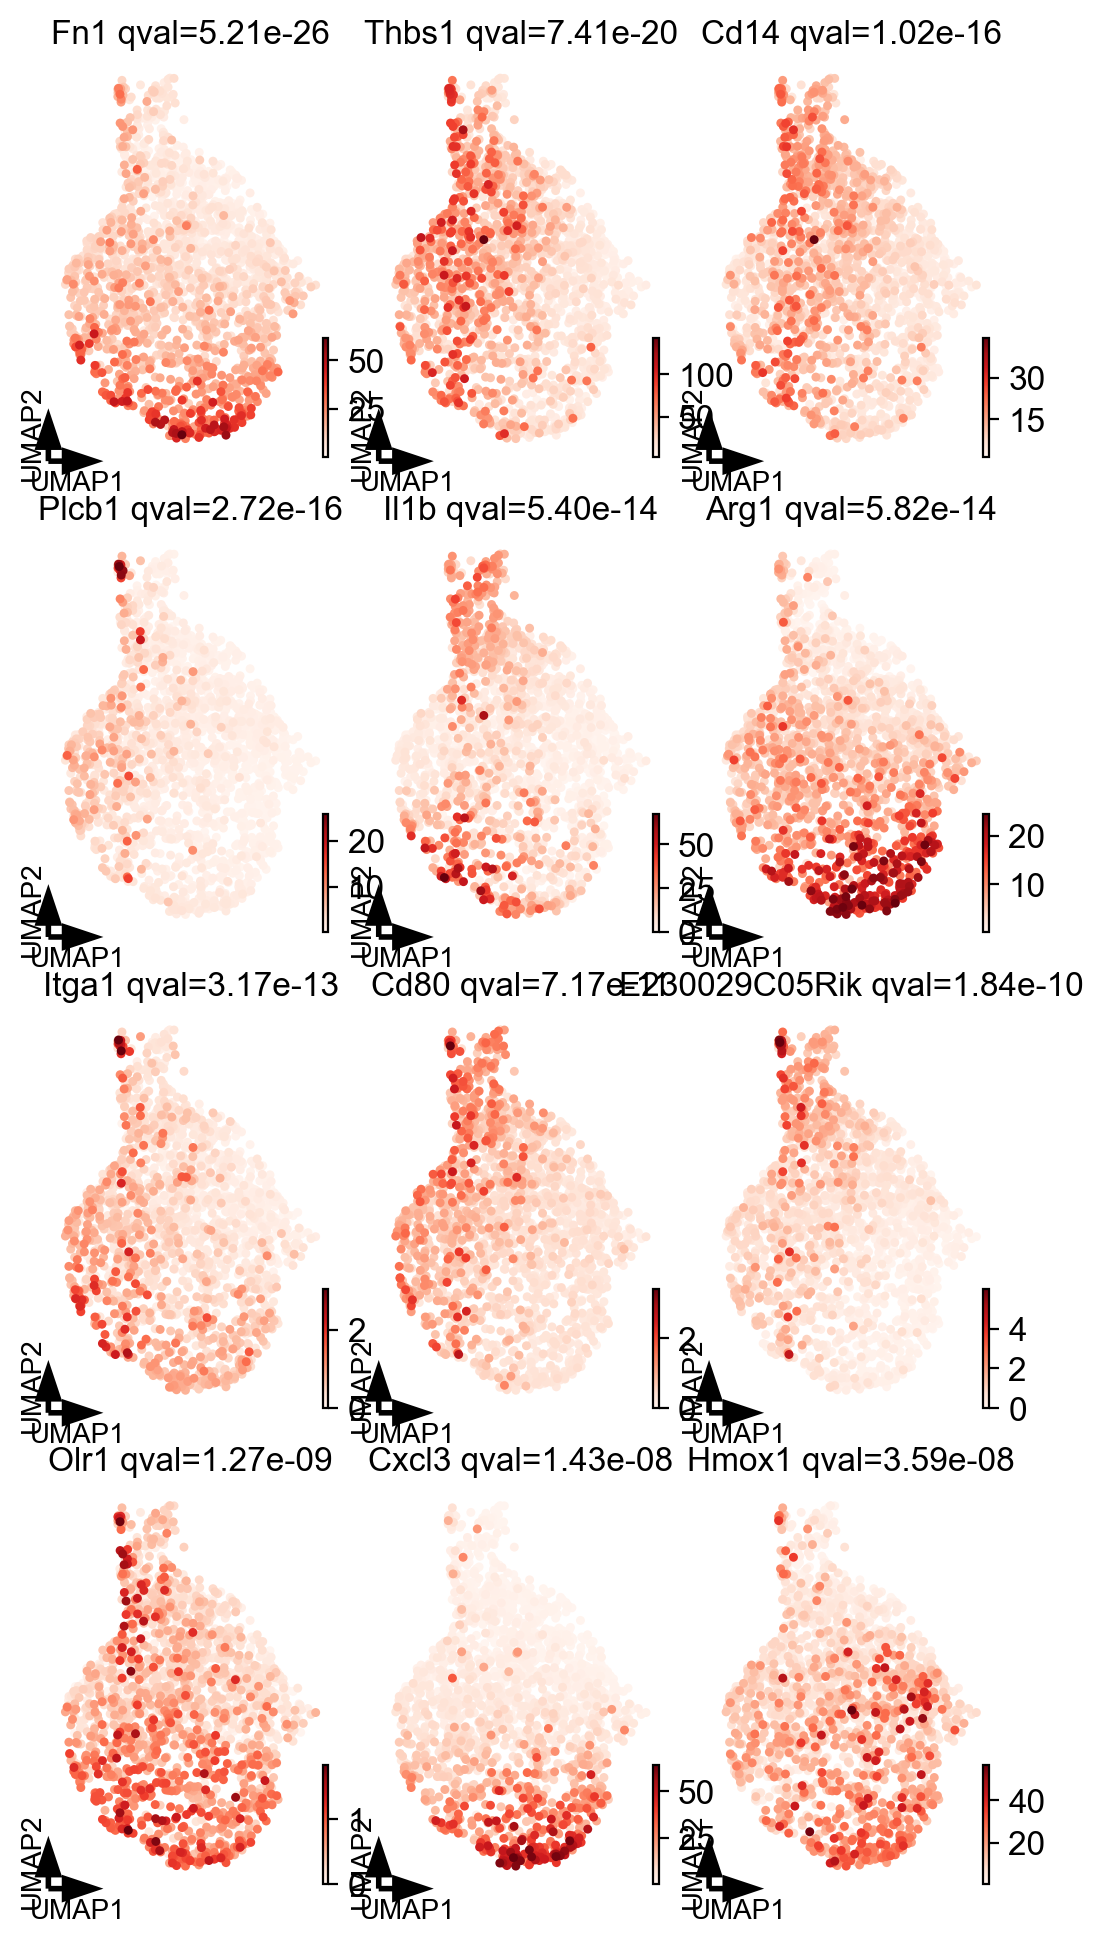

In [18]:
cr.pl.lineage_drivers(adata,
                      lineage = 'MAC2',
                      n_genes = 12,
                      ncols = 3,
                      figsize = (6,12),
                      title_fmt='{gene} qval={qval:.2e}',
                      save = 'uninfected/uninfected_immune_lineage_drivers_rescaled.pdf',
                      color_map = 'Reds',
                      smooth = True,
                      wspace = 5,
                     )

 ### Gene expression trends

In [19]:
## compute DPT, starting from CellRank defined root cell
root_idx = np.where(adata.obs["initial_states"] == "MAC2")[0][0]
adata.uns["iroot"] = root_idx
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file ./figures/uninfected/uninfected_immune_root_latent_dpt.pdf


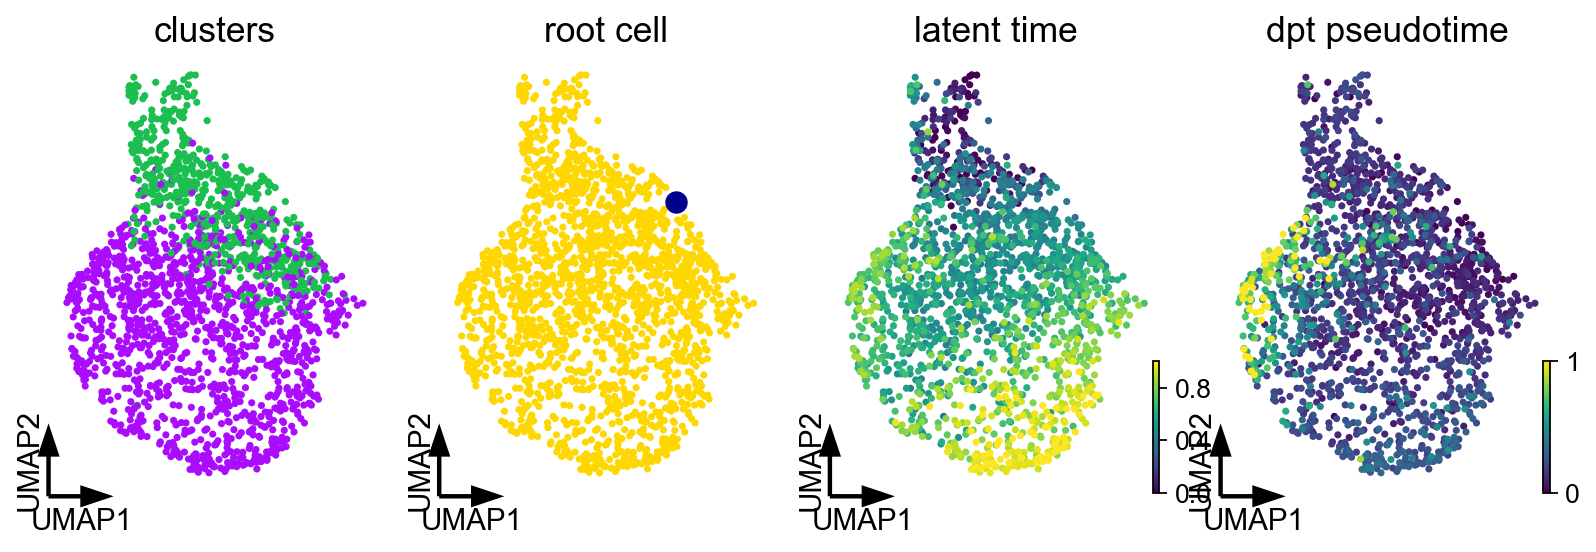

In [21]:
scv.pl.scatter(adata,
               color = ["seurat_clusters", root_idx, "latent_time", "dpt_pseudotime"],
               fontsize = 16,
               cmap = "viridis",
               perc = [2, 98],
               colorbar = True,
               rescale_color = [0, 1],
               figsize = (2.5,3),
               title = ["clusters", "root cell", "latent time", "dpt pseudotime"],
               save = 'immune_root_latent_dpt.pdf'
              )

In [23]:
model = cr.ul.models.GAM(adata)

Computing trends using `10` core(s)


  0%|          | 0/12 [00:00<?, ?gene/s]

    Finish (0:00:21)
Plotting trends


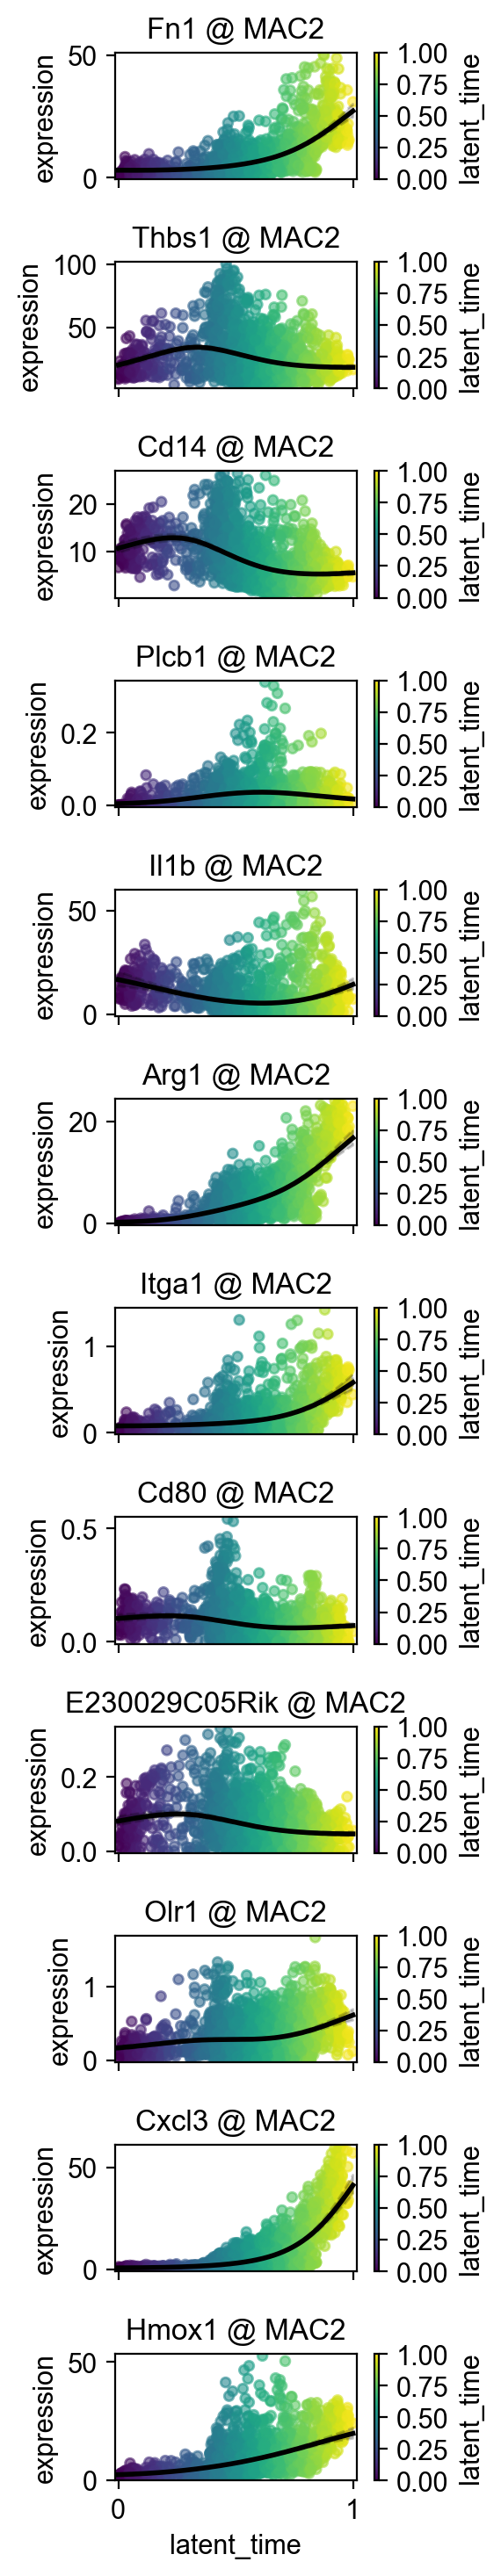

In [24]:
genes = adata.varm['terminal_lineage_drivers']["MAC2_corr"].sort_values(ascending=False).index[:12]

cr.pl.gene_trends(adata,
                  model = model,
                  data_key = "Ms",
                  genes = genes,
                  lineages = 'MAC2',
                  time_key = "latent_time",
                  same_plot = False,
                  hide_cells = False,
                  show_progress_bar = False,
                  figsize = (3, 15),
                  gene_as_title = True,
                  cell_color = 'latent_time',
                  n_jobs = 10,
                  time_range=[(0,0.6)],
                  save = 'uninfected/uninfected_immune_gene_trends.pdf'
                 )

Computing trends using `1` core(s)


  0%|          | 0/30 [00:00<?, ?gene/s]

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish

    Finish (0:00:02)


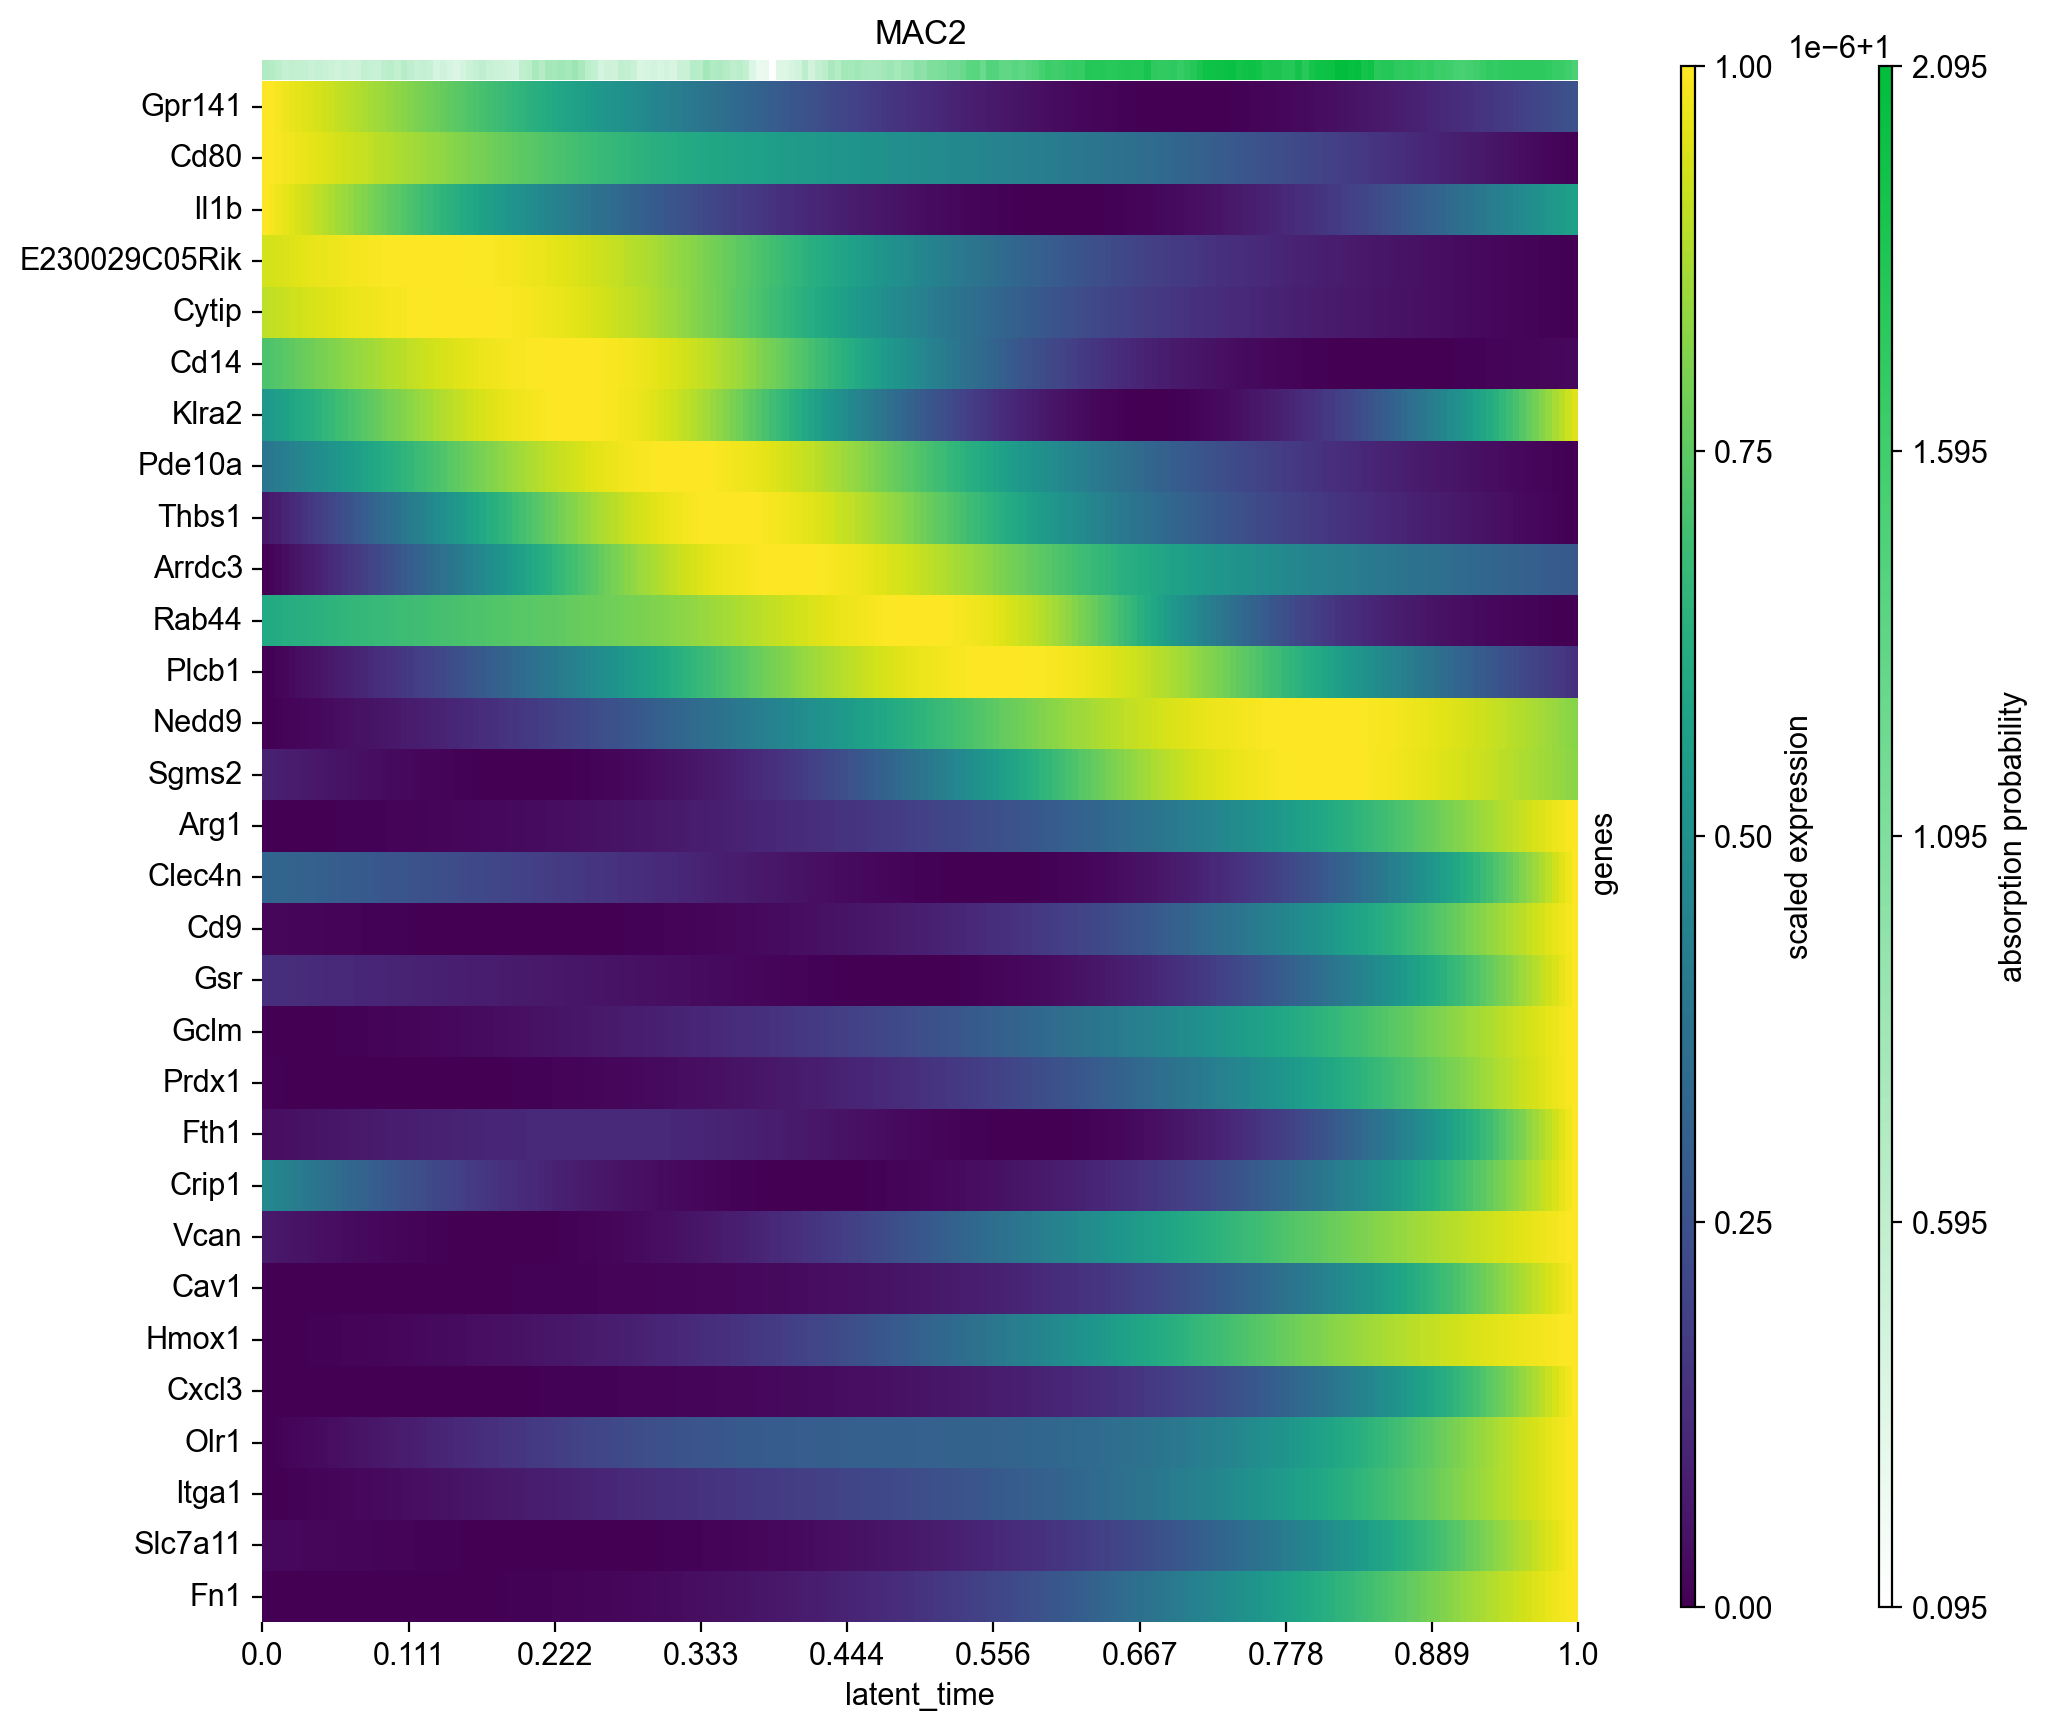

In [25]:
cr.pl.heatmap(adata,
              model,
              genes = adata.varm['terminal_lineage_drivers']["MAC2_corr"].sort_values(ascending=False).index[:30],
              show_absorption_probabilities = True,
              lineages = "MAC2",
              n_jobs = 1,
              backend = "loky",
              figsize = (10,10),
              save = 'uninfected/uninfected_immune_terminal_lineage_drivers.pdf'
             )

Computing trends using `1` core(s)


  0%|          | 0/30 [00:00<?, ?gene/s]

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish

    Finish (0:00:02)


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish

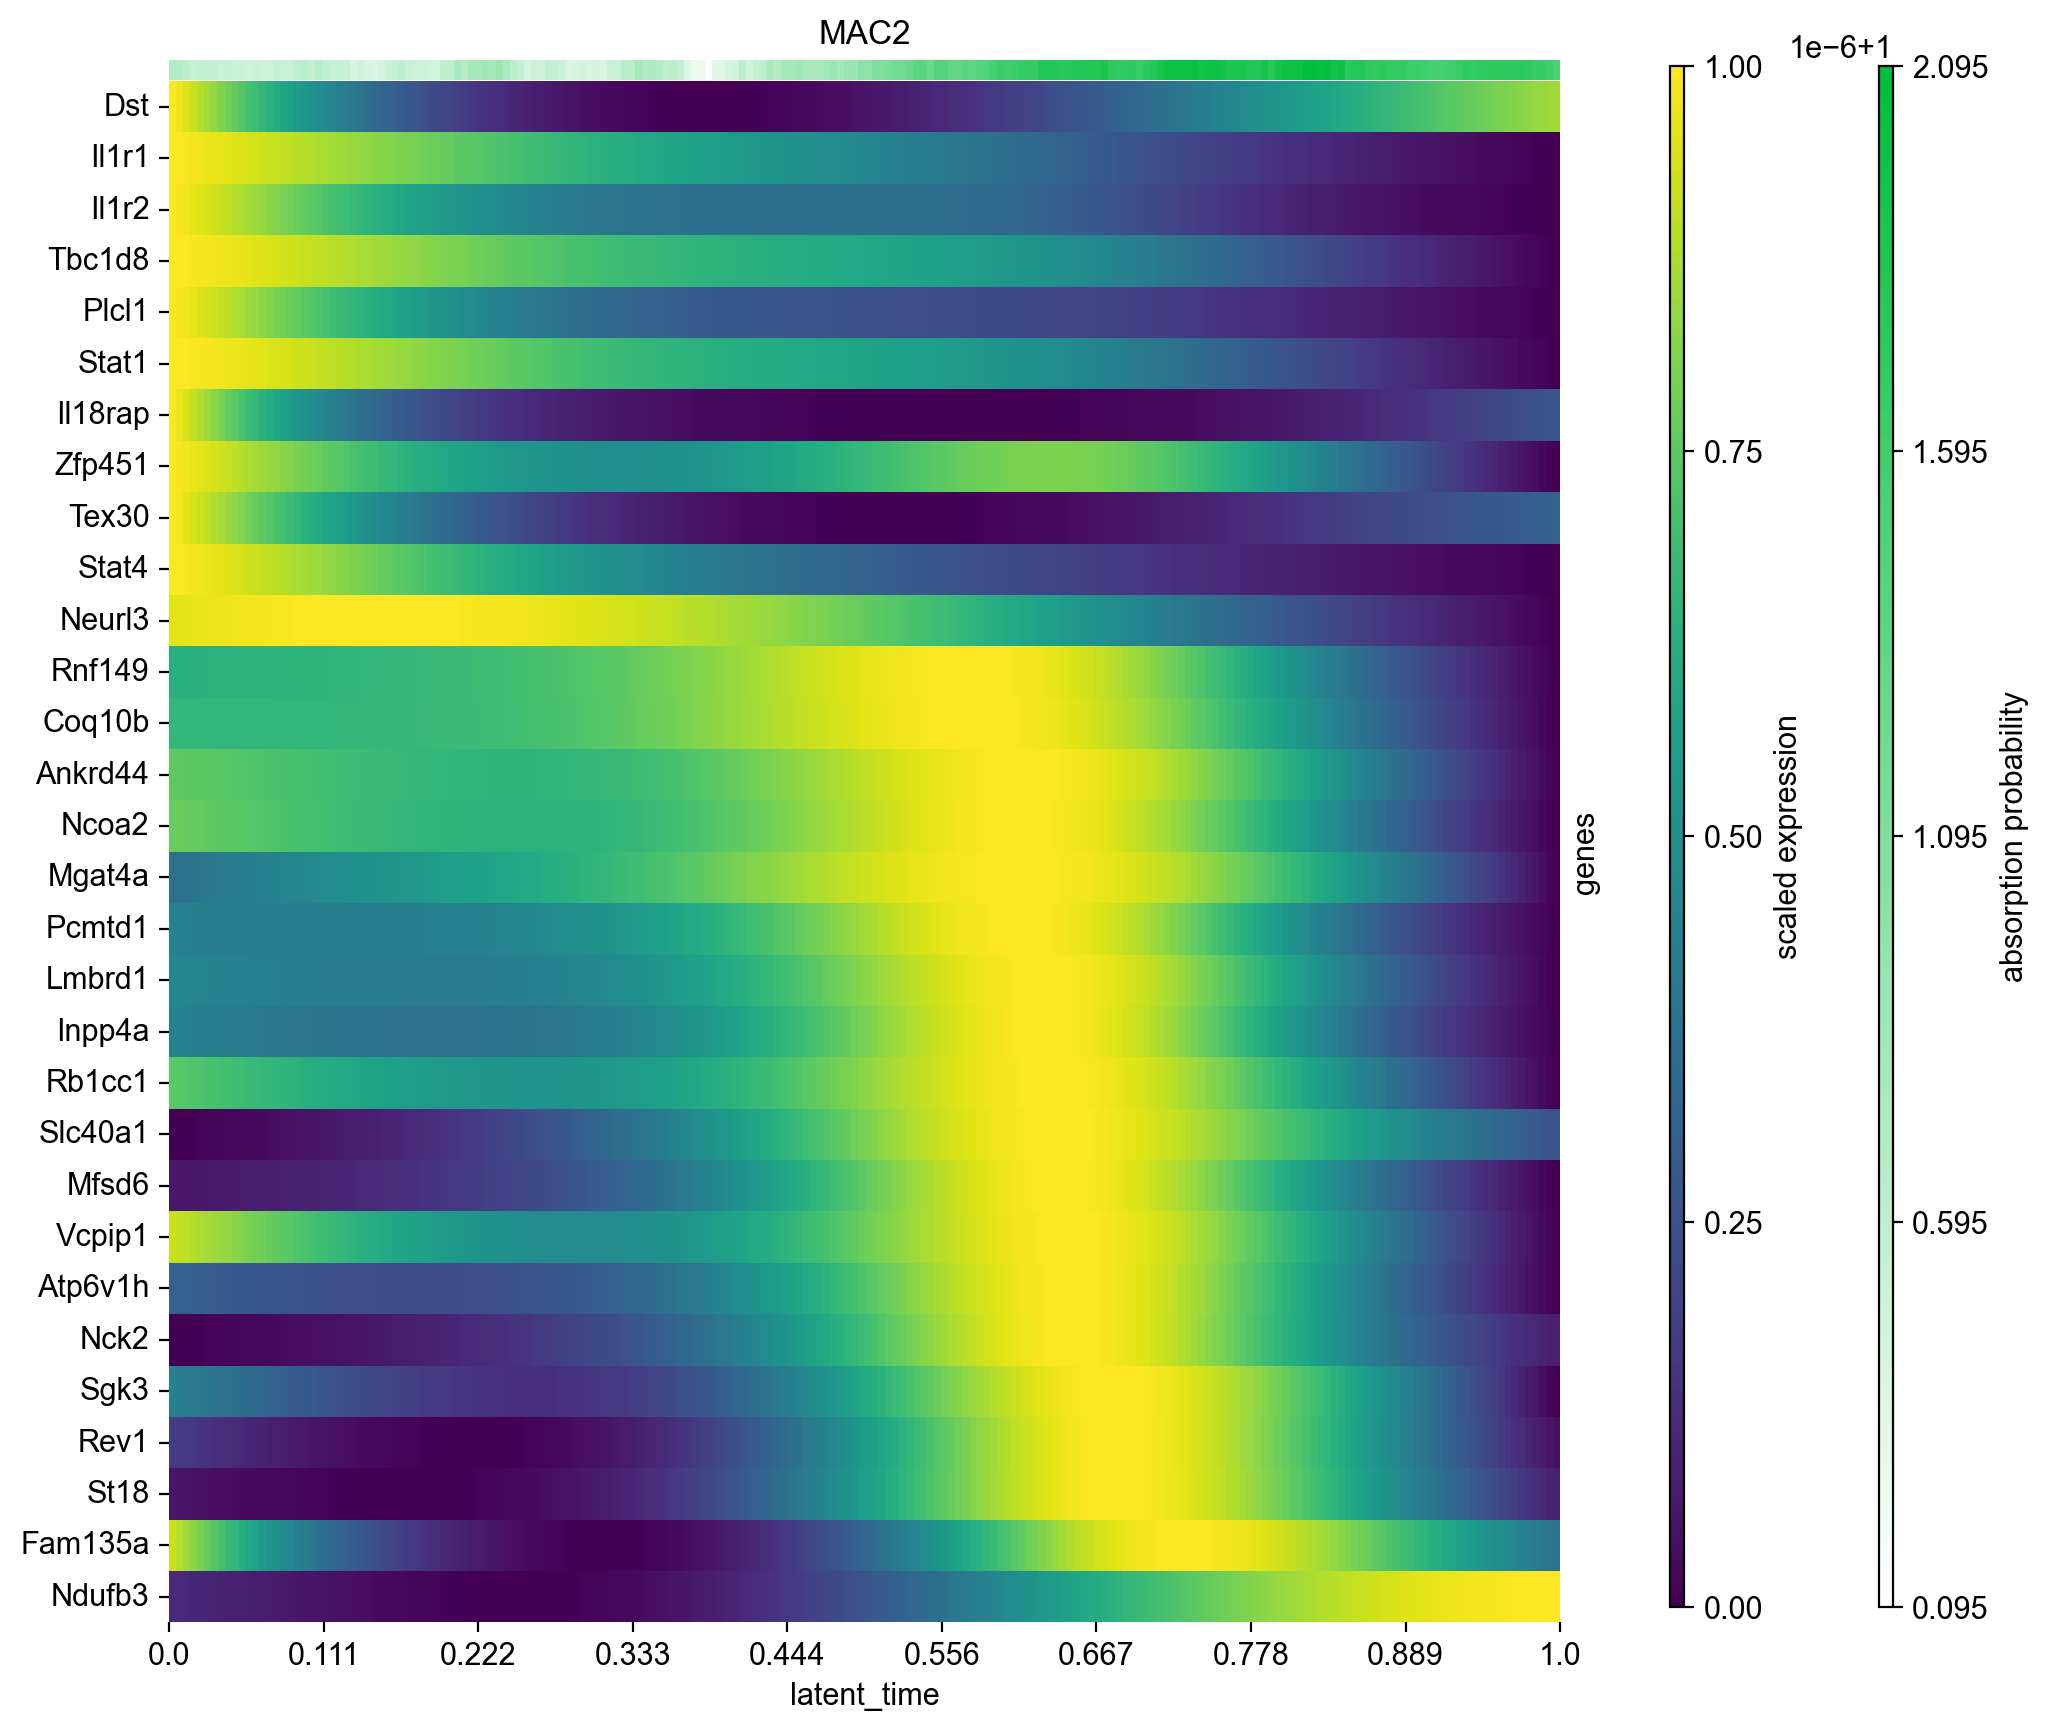

In [26]:
cr.pl.heatmap(adata,
              model,
              adata.var_names[:30],
              time_key = 'latent_time',
              lineages = 'MAC2',
              show_progress_bar = False,
              show_absorption_probabilities = True,
              figsize = (10, 10),
              save ='uninfected/uninfected_immune_latent_time.pdf',
              return_genes = False)

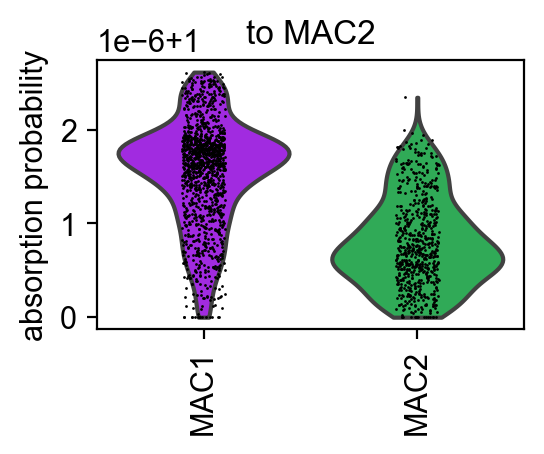

In [27]:
cr.pl.cluster_fates(adata, mode = "violin",
                    cluster_key = "seurat_clusters",
                    lineages = 'MAC2',
                    figsize = (3,2),
                    save = 'uninfected/uninfected_immune_aggregated_cluster_fates.pdf'
                   )

In [28]:
genes = adata.varm['terminal_lineage_drivers']["MAC2_corr"].sort_values(ascending=False).index[:50]
scv.tl.differential_kinetic_test(adata, var_names=genes, groupby='seurat_clusters')

recovering dynamics (using 1/12 cores)


  0%|          | 0/15 [00:00<?, ?gene/s]

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:05)
testing for differential kinetics
    finished (0:00:04)


In [29]:
scv.get_df(adata[:, genes], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/core/_anndata.py:306: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.var_names = df.index


fit_diff_kinetics  fit_pval_kinetics
Thbs1                      MAC2           3.78e-03
E230029C05Rik              MAC2           1.77e-03
Vcan                       MAC2           7.21e-06
Cytip                      MAC2           1.49e-04
Arrdc3                     MAC2           8.63e-03
Klra2                      MAC2           5.97e-05
Gsr                        MAC2           2.88e-06
Nedd9                      MAC2           9.98e-03
Gpr141                     MAC2           6.04e-06
Nt5e                       MAC2           5.76e-04
Havcr2                     MAC2           1.06e-03
Resf1                      MAC2           4.00e-03

In [30]:
kwargs = dict(linewidth=2, add_linfit=True, frameon='artist')

saving figure to file ./figures/uninfected/uninfected_diff_kinetics.pdf


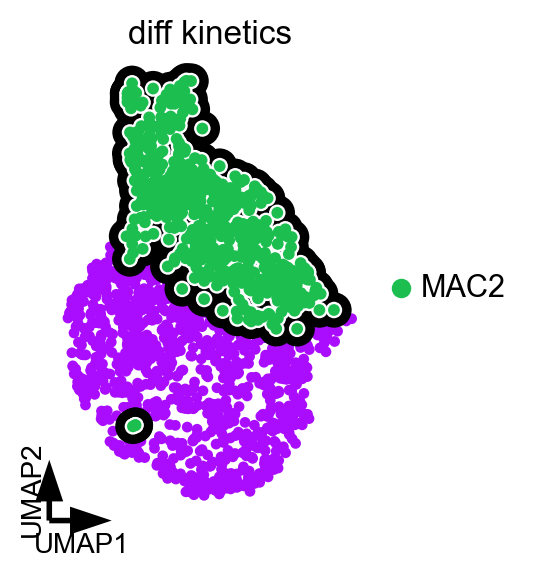

In [31]:
diff_clusters=list(adata[:, genes].var['fit_diff_kinetics'])

scv.pl.scatter(adata, legend_loc='right', size=60, title='diff kinetics',
               add_outline=diff_clusters, outline_width=(.8, .2), color='seurat_clusters', figsize=(2,3),
               save='diff_kinetics.pdf')

In [32]:
# top-likelihood genes
scv.tl.recover_dynamics(adata, n_jobs=10)
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='seurat_clusters')

recovering dynamics (using 10/12 cores)


  0%|          | 0/309 [00:00<?, ?gene/s]

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:32)
testing for differential kinetics
    finished (0:00:09)


saving figure to file ./figures/uninfected/uninfected_top_likelihood_15.pdf


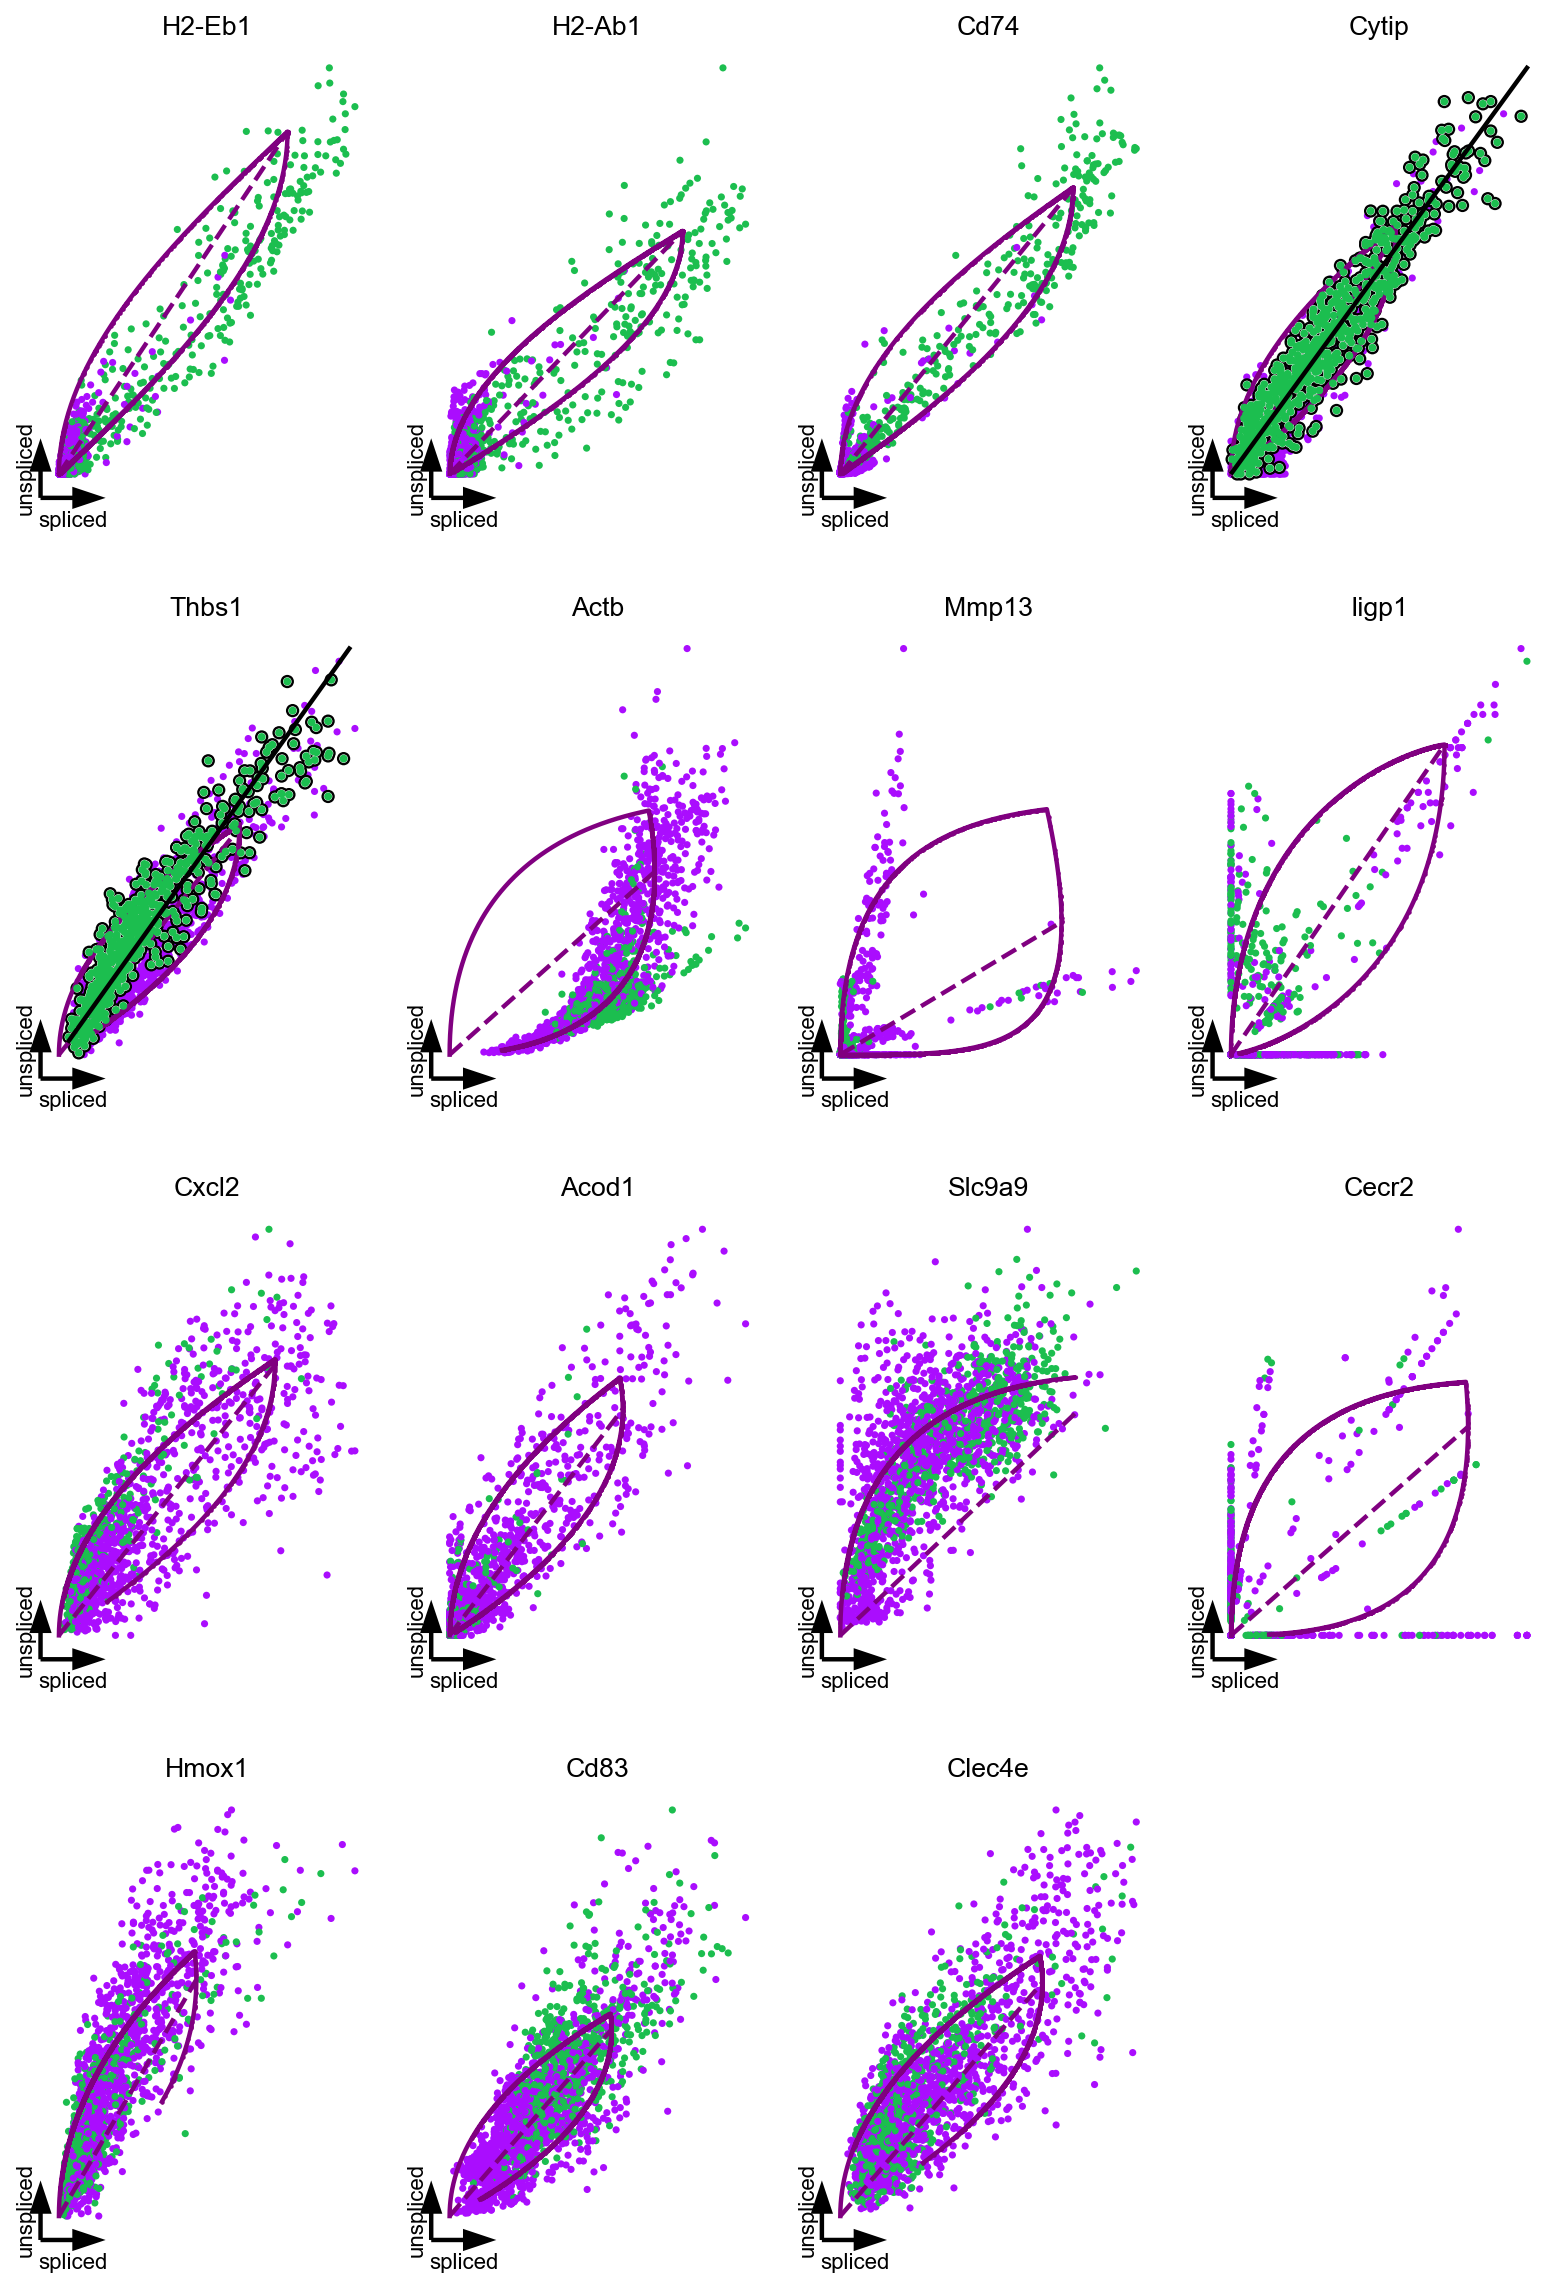

saving figure to file ./figures/uninfected/uninfected_top_likelihood_15_latent.pdf


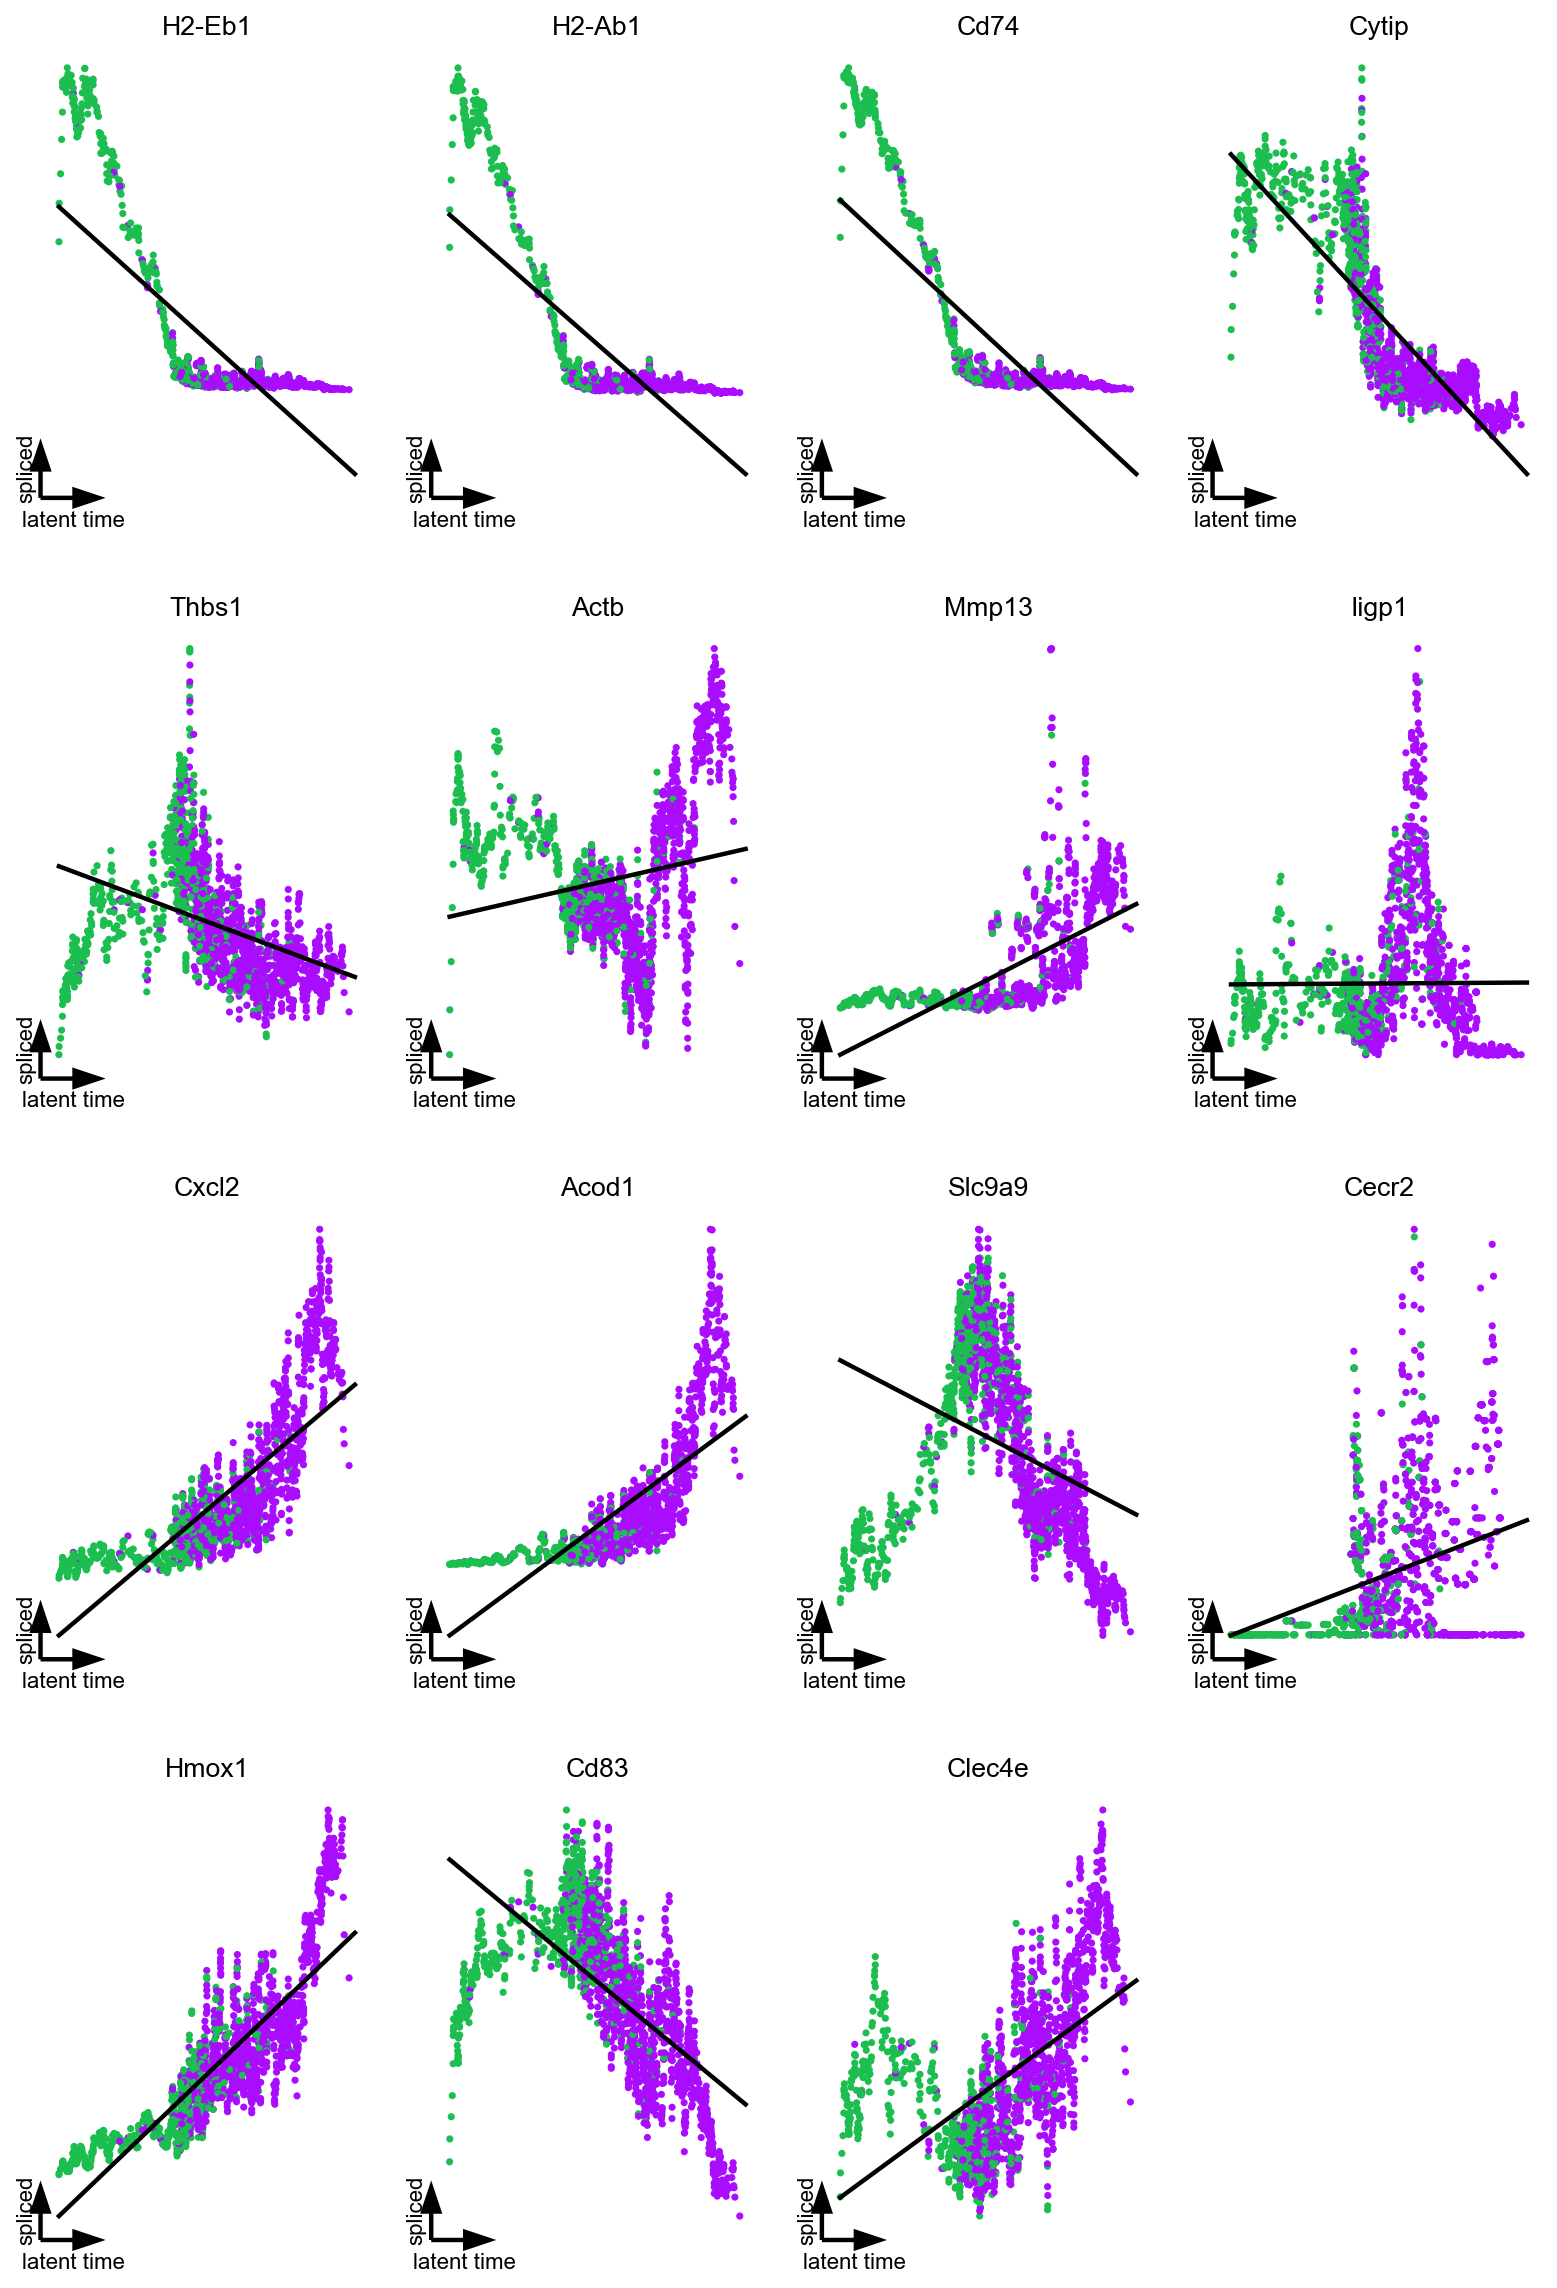

In [33]:
scv.pl.scatter(adata, basis=top_genes[:15], ncols=4, add_outline='fit_diff_kinetics', **kwargs, save='top_likelihood_15', smooth=True)
scv.pl.scatter(adata, x='latent_time', y=top_genes[:15], save='top_likelihood_15_latent', color='seurat_clusters', **kwargs, ncols=4, n_convolve=10, smooth=True)

saving figure to file ./figures/uninfected/uninfected_top_likelihood_30.pdf


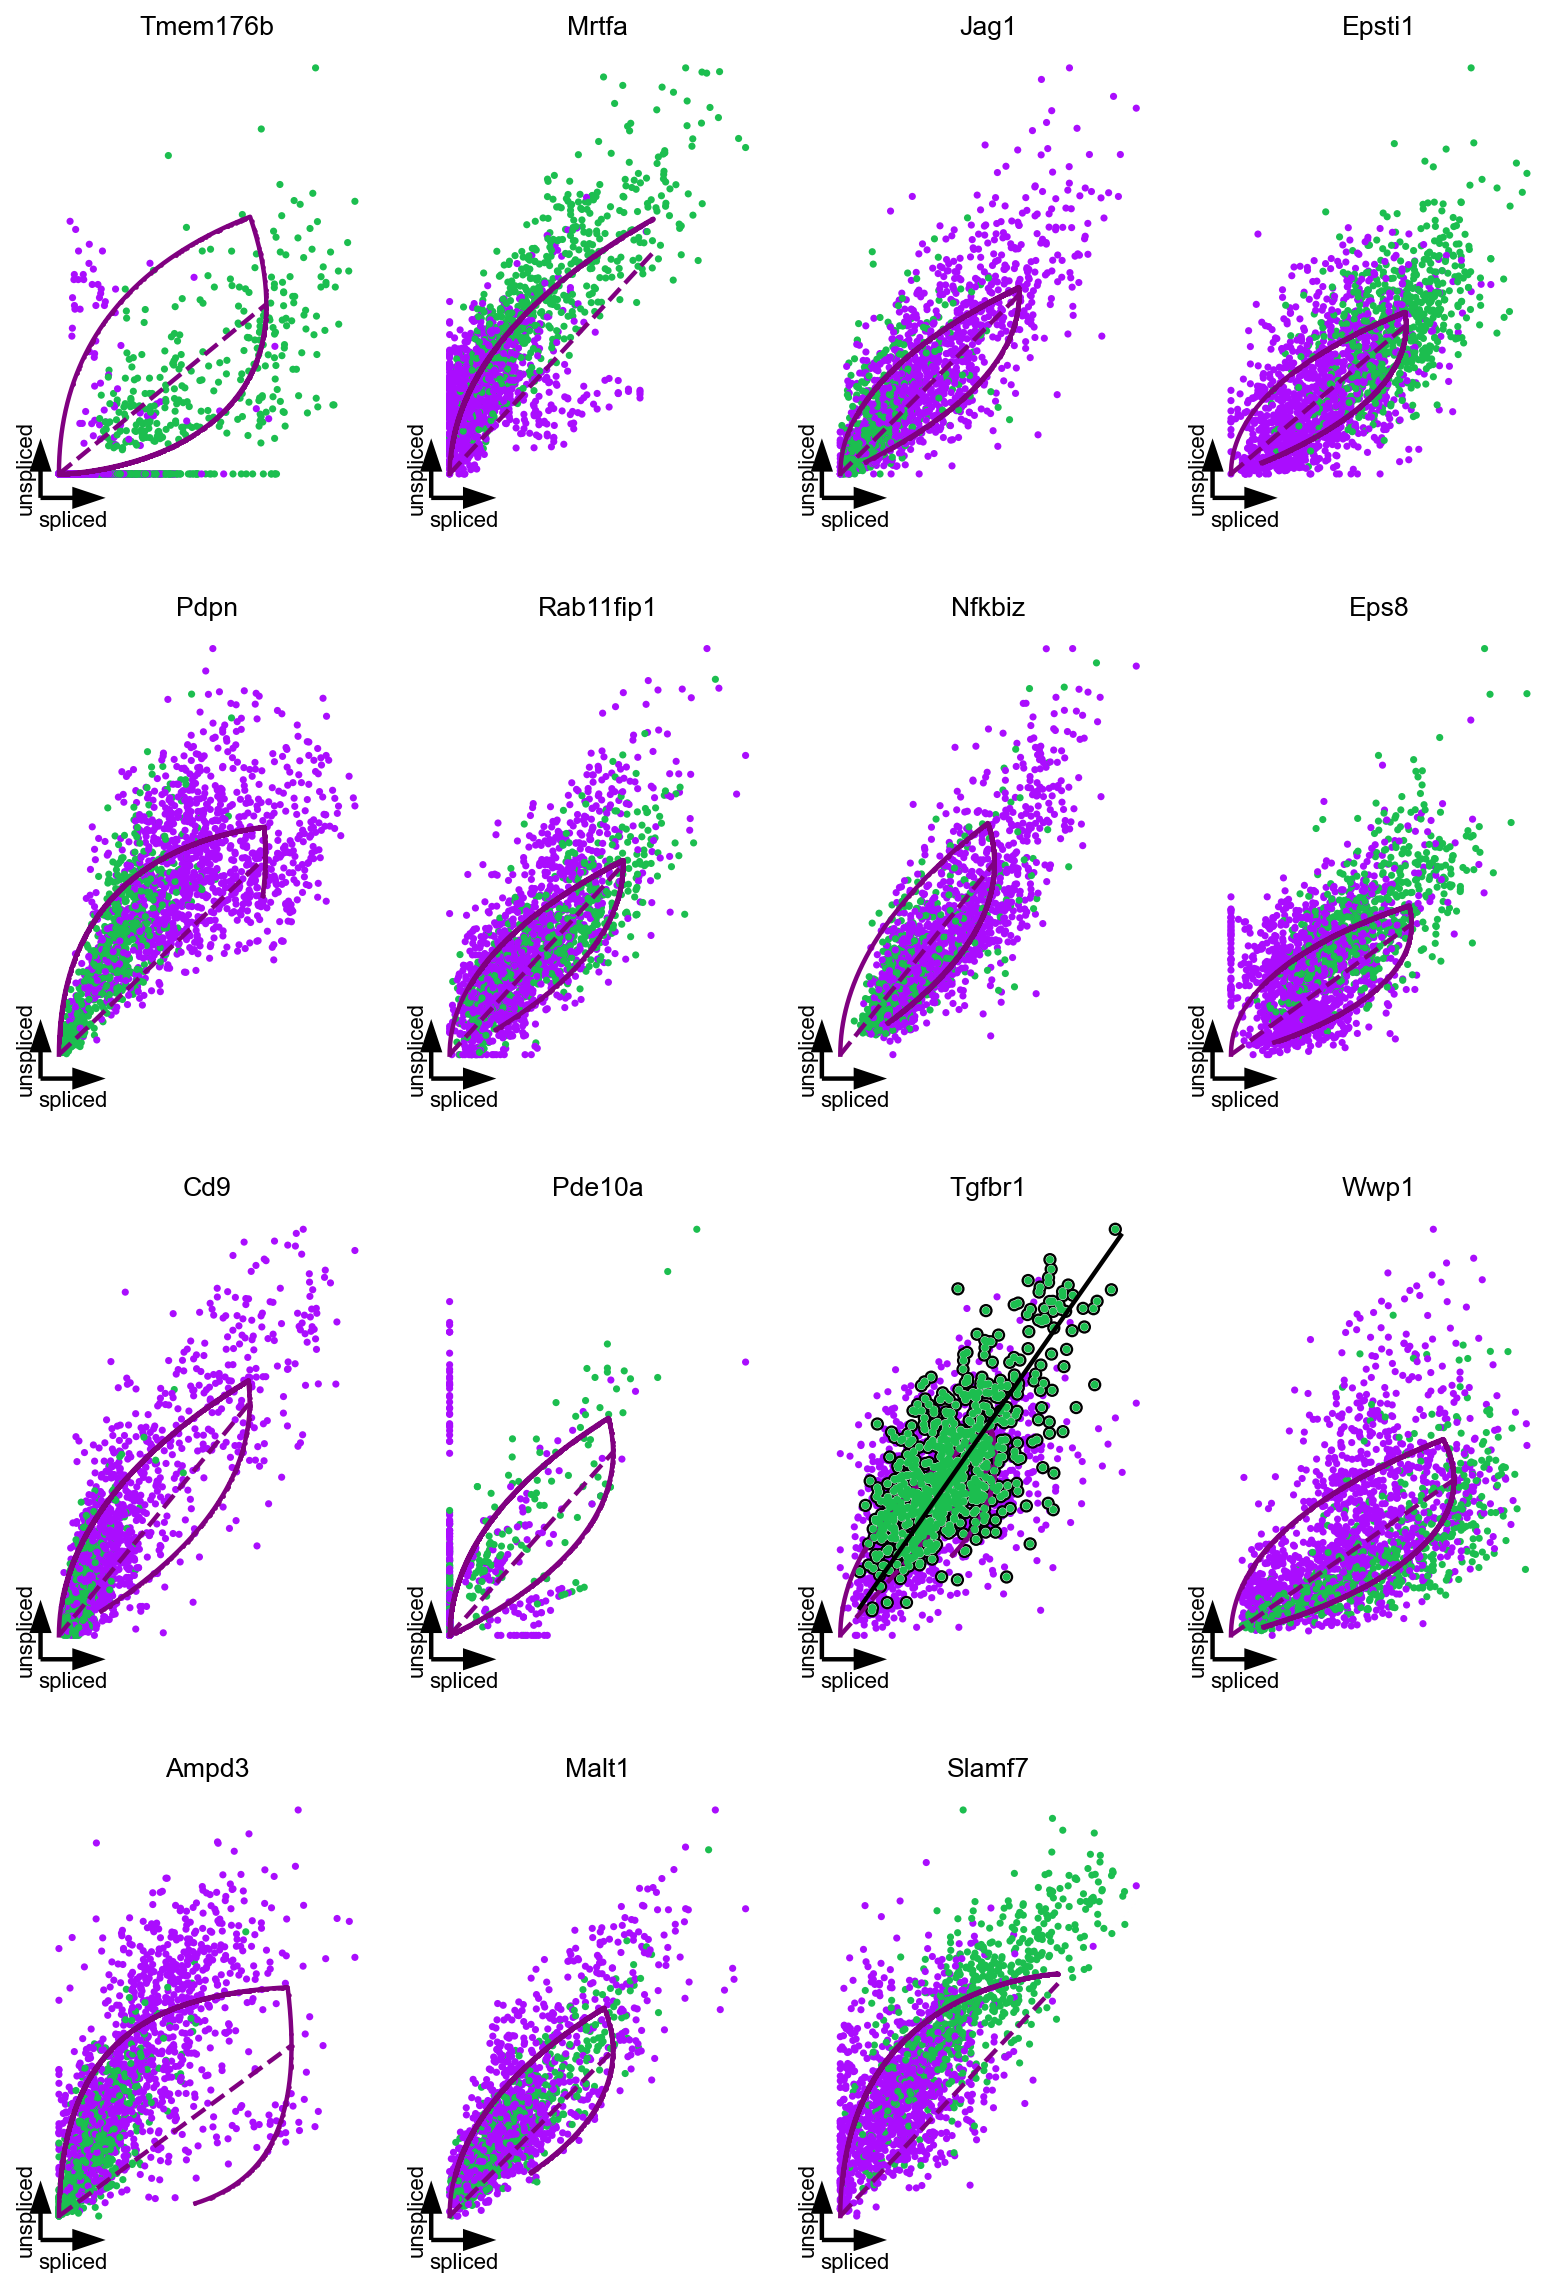

saving figure to file ./figures/uninfected/uninfected_top_likelihood_30_latent.pdf


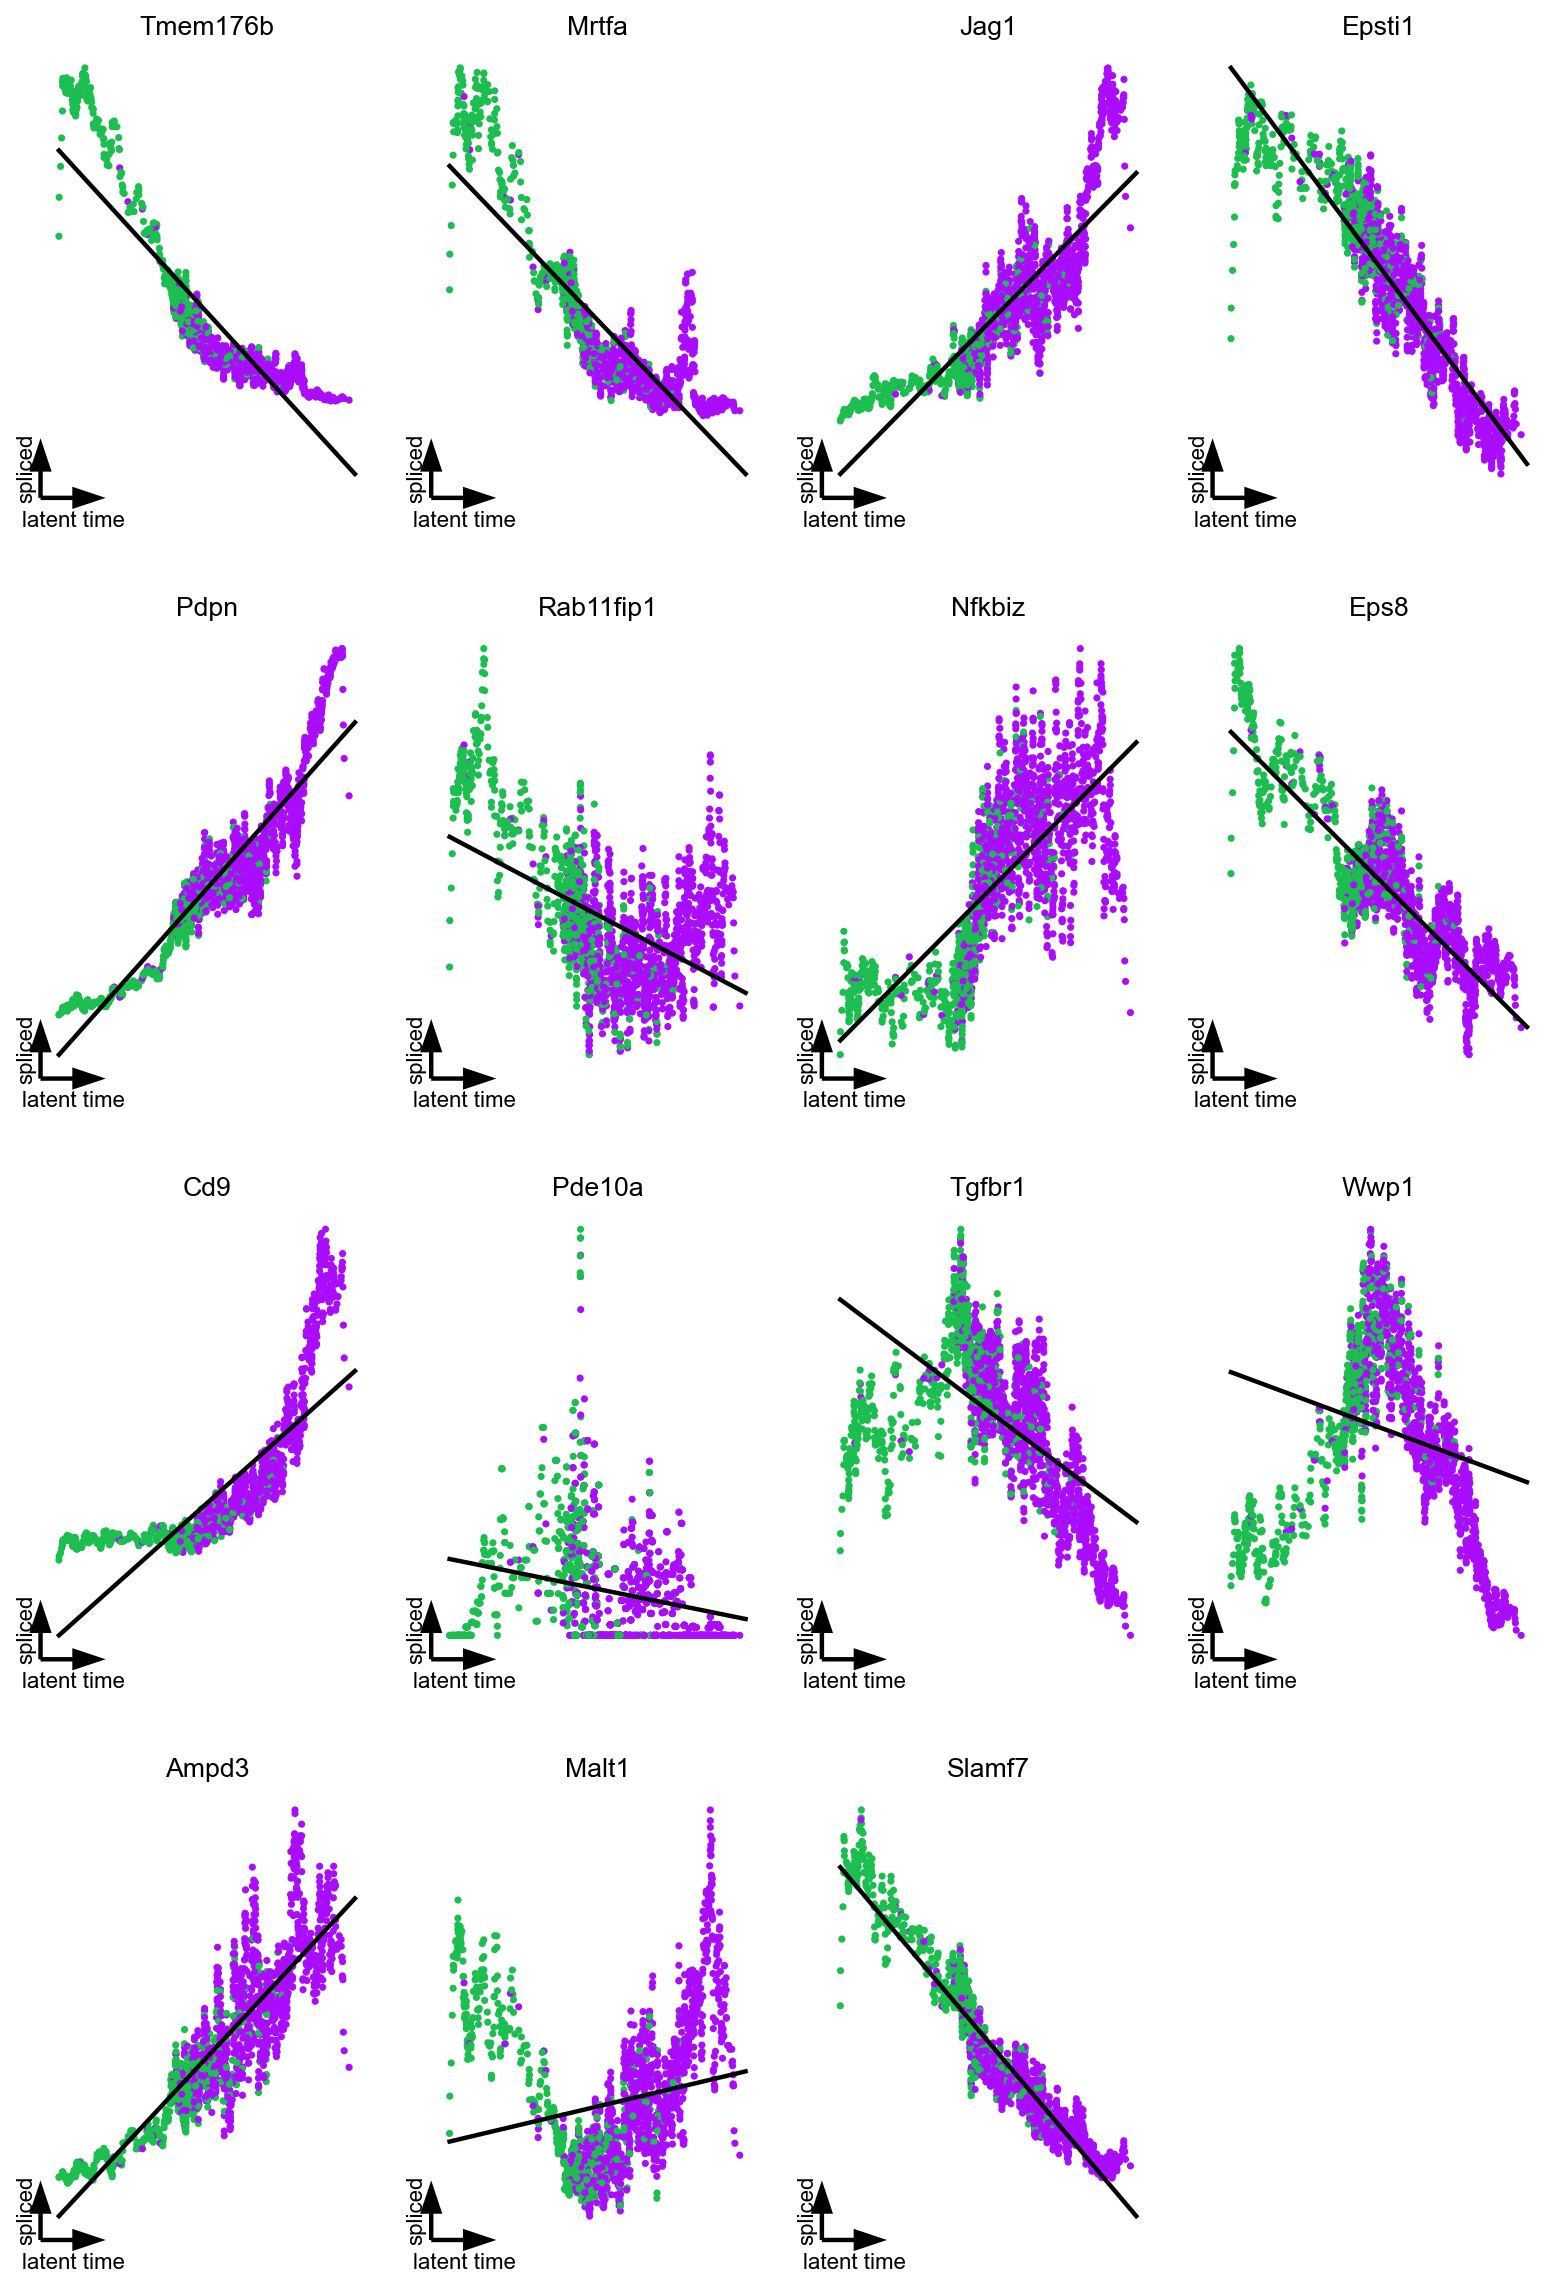

In [34]:
scv.pl.scatter(adata, basis=top_genes[15:30], ncols=4, add_outline='fit_diff_kinetics', **kwargs,save='top_likelihood_30', smooth=True)
scv.pl.scatter(adata, x='latent_time', y=top_genes[15:30], save='top_likelihood_30_latent', color='seurat_clusters',
               **kwargs, ncols=4, n_convolve=10, smooth=True)

In [ ]:
import session_info
session_info.show()